In [1]:
!du -h *

19M	CCA.zip
4.0K	Untitled.ipynb
4.0K	Variables CCA.txt
0	current_raster.sql
36K	hcho_2004-2018.sql
516K	hcho_2004-2018.tif
71M	mex_wc2.1_30s_bio.tar.gz
31M	mex_wc2.1_30s_bio_1.tif
31M	mex_wc2.1_30s_bio_10.tif
31M	mex_wc2.1_30s_bio_11.tif
31M	mex_wc2.1_30s_bio_12.tif
31M	mex_wc2.1_30s_bio_13.tif
31M	mex_wc2.1_30s_bio_14.tif
31M	mex_wc2.1_30s_bio_15.tif
31M	mex_wc2.1_30s_bio_16.tif
31M	mex_wc2.1_30s_bio_17.tif
31M	mex_wc2.1_30s_bio_18.tif
31M	mex_wc2.1_30s_bio_19.tif
31M	mex_wc2.1_30s_bio_2.tif
31M	mex_wc2.1_30s_bio_3.tif
31M	mex_wc2.1_30s_bio_4.tif
31M	mex_wc2.1_30s_bio_5.tif
31M	mex_wc2.1_30s_bio_6.tif
31M	mex_wc2.1_30s_bio_7.tif
31M	mex_wc2.1_30s_bio_8.tif
31M	mex_wc2.1_30s_bio_9.tif
80K	mex_wc2.sql
3.2M	muni_2016gw.dbf
4.0K	muni_2016gw.prj
51M	muni_2016gw.shp
20K	muni_2016gw.shx
40K	no2_2004-2018.sql
516K	no2_2004-2018.tif
396K	pedro@10.90.0.38
68K	precmaxext.sql
34M	precmaxext.tif
436K	process_raster-Copy1.ipynb
588K	process_raster.ipynb
31M	reclassified_raster.tif
44K	so2_2004-2018

In [2]:
descriptions = ['Annual Mean Temperature', 
                'Mean Diurnal Range (Mean of monthly (max temp - min temp))', 
                'Isothermality (BIO2/BIO7) (×100)', 
                'Temperature Seasonality (standard deviation ×100)', 
                'Max Temperature of Warmest Month', 
                'Min Temperature of Coldest Month', 
                'Temperature Annual Range (BIO5-BIO6)', 
                'Mean Temperature of Wettest Quarter', 
                'Mean Temperature of Driest Quarter', 
                'Mean Temperature of Warmest Quarter', 
                'Mean Temperature of Coldest Quarter', 
                'Annual Precipitation', 
                'Precipitation of Wettest Month', 
                'Precipitation of Driest Month', 
                'Precipitation Seasonality (Coefficient of Variation)', 
                'Precipitation of Wettest Quarter', 
                'Precipitation of Driest Quarter', 
                'Precipitation of Warmest Quarter', 
                'Precipitation of Coldest Quarter']

In [3]:
import gdal, ogr
import numpy as np
from matplotlib import pyplot
from sqlalchemy import create_engine

import pandas as pd
import fiona
import rasterio
import rasterio.mask

import psycopg2

raster_name = "./mex_wc2.1_30s_bio_19.tif"
no_percentiles = 20
label = descriptions[18]

dbname = 'epi_puma_worldclim'
dbuser = 'postgres'
dbport = 5433
dbhost = '10.90.0.38'
dbpass = '!37JzLg+9M2RAu72'

### Getting data and info of layer

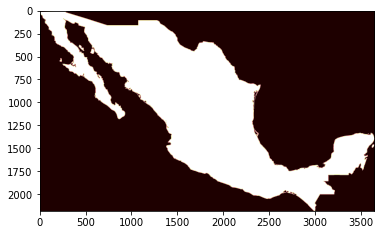

In [4]:
src = rasterio.open(raster_name)
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

In [5]:
layer = gdal.Open(raster_name)

raster_info = {
                'xsize': layer.RasterXSize,
                'ysize': layer.RasterYSize,
                'geo_transformation': layer.GetGeoTransform(),
                'projection': layer.GetProjection()
              }

data = layer.ReadAsArray()

raster_info

{'xsize': 3645,
 'ysize': 2180,
 'geo_transformation': (-117.12359619140625,
  0.008334317096139831,
  0.0,
  32.718318939208984,
  0.0,
  -0.008334971786639013),
 'projection': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}

### Closing raster file

In [6]:
layer = None

### How looks the extracted data

In [7]:
data

array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       ...,
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38]],
      dtype=float32)

In [8]:
data.shape

(2180, 3645)

### Shape, max and min of extracted data

In [9]:
[data.shape, data.max(), data.min()]

[(2180, 3645), 976.0, -3.4e+38]

### Masking nondata value

In [10]:
data = np.ma.masked_less(data, value=-3e+38)

In [11]:
data

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [12]:
p = np.linspace(start=0, stop=100, num=no_percentiles + 1) 
percentiles = np.nanpercentile(np.where(np.logical_not(data.mask), data, np.NAN), p)

In [13]:
percentiles

array([  0.,  20.,  24.,  26.,  29.,  31.,  34.,  36.,  39.,  42.,  46.,
        52.,  59.,  66.,  74.,  88., 105., 123., 148., 194., 976.])

In [14]:
labels = ['{}:{}'.format(f"{interval[0]:.3f}", f"{interval[1]:.3f}") for interval in zip(percentiles[:-1],percentiles[1:])]
labels

['0.000:20.000',
 '20.000:24.000',
 '24.000:26.000',
 '26.000:29.000',
 '29.000:31.000',
 '31.000:34.000',
 '34.000:36.000',
 '36.000:39.000',
 '39.000:42.000',
 '42.000:46.000',
 '46.000:52.000',
 '52.000:59.000',
 '59.000:66.000',
 '66.000:74.000',
 '74.000:88.000',
 '88.000:105.000',
 '105.000:123.000',
 '123.000:148.000',
 '148.000:194.000',
 '194.000:976.000']

In [15]:
data.filled(2*percentiles[-1])

array([[1952., 1952., 1952., ..., 1952., 1952., 1952.],
       [1952., 1952., 1952., ..., 1952., 1952., 1952.],
       [1952., 1952., 1952., ..., 1952., 1952., 1952.],
       ...,
       [1952., 1952., 1952., ..., 1952., 1952., 1952.],
       [1952., 1952., 1952., ..., 1952., 1952., 1952.],
       [1952., 1952., 1952., ..., 1952., 1952., 1952.]], dtype=float32)

### Reclassfying data

In [16]:
reclass = np.searchsorted(percentiles[1:], data.filled(2*percentiles[-1]))
reclass

array([[20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       ...,
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20]])

In [17]:
np.unique(reclass, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([ 135735,  162225,   94346,  153107,  107692,  135130,   89259,
         139207,  125891,  113792,  125384,  129555,  122021,  112136,
         127569,  126229,  119118,  128462,  121352,  124001, 5453889]))

In [18]:
reclass.shape

(2180, 3645)

In [19]:
reclass += 1
reclass = np.ma.masked_equal(reclass, percentiles.shape[0])

In [20]:
reclass

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=21)

In [21]:
np.unique(reclass, return_counts=True)

(masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                    17, 18, 19, 20, --],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, False, False,  True],
        fill_value=21),
 array([ 135735,  162225,   94346,  153107,  107692,  135130,   89259,
         139207,  125891,  113792,  125384,  129555,  122021,  112136,
         127569,  126229,  119118,  128462,  121352,  124001, 5453889]))

In [22]:
reclass.dtype.name ## 5

'int64'

### Turning reclassified data into a raster

In [23]:
rows, cols = reclass.shape
projection = raster_info['projection']
geo_transformation = raster_info['geo_transformation']

print(projection,'-', geo_transformation)

driver = gdal.GetDriverByName('GTiff')
ds = driver.Create('./reclassified_raster.tif', cols, rows, 1, 5)
ds.SetGeoTransform(geo_transformation)
ds.SetProjection(projection)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] - (-117.12359619140625, 0.008334317096139831, 0.0, 32.718318939208984, 0.0, -0.008334971786639013)


0

In [24]:
nodata = reclass.fill_value
nodata

21

In [25]:
reclass = reclass.filled()

In [26]:
reclass

array([[21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       ...,
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21]])

In [27]:
np.unique(reclass, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21]),
 array([ 135735,  162225,   94346,  153107,  107692,  135130,   89259,
         139207,  125891,  113792,  125384,  129555,  122021,  112136,
         127569,  126229,  119118,  128462,  121352,  124001, 5453889]))

In [28]:
band = ds.GetRasterBand(1)
band.WriteArray(reclass)

band.SetNoDataValue(float(nodata))
band.FlushCache()

#ds.SetGeoTransform(geo_transformation)
#ds.SetProjection(projection)

ds = None

#driver = gdal.GetDriverByName('GTiff')
#ds = driver.Create('./reclassified_raster.tif', cols, rows, 1, 5)

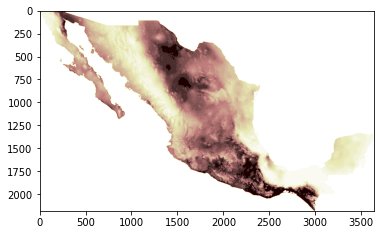

In [29]:
src = rasterio.open("./reclassified_raster.tif")
pyplot.imshow(src.read(1), cmap='pink')
pyplot.show()

### Obtaining polygons from db

In [30]:
with fiona.open("./muni_2016gw.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    cves = [feature['properties']["CVE_ENT"] + feature['properties']["CVE_MUN"] for feature in shapefile]
    print(shapefile[0]['properties'])
    
    
N = len(shapes)
cells_bins = {}
counts_d = {i:0 for i in range(1, no_percentiles + 2)}
    
with rasterio.open("./reclassified_raster.tif") as src:
    for i in range(N):
        feature = shapes[i]
        out_image, out_transform = rasterio.mask.mask(src, [feature], crop=True)
        bins, counts = np.unique(out_image, return_counts=True)
        for j in range(len(bins)):
            counts_d[bins[j]] += counts[j]
        if cves[i] in cells_bins.keys():
            cells_bins[cves[i]] += [b for b in bins if b != no_percentiles + 1]
            cells_bins[cves[i]] = list(set(cells_bins[cves[i]]))
        else:
            cells_bins[cves[i]] = [b for b in bins if b != no_percentiles + 1]

OrderedDict([('OBJECTID', 1), ('CVE_ENT', '01'), ('NOM_ENT', 'Aguascalientes'), ('CVE_MUN', '002'), ('NOM_MUN', 'Asientos'), ('CVEGEO', '01002'), ('AREA', 54337.42658), ('PERIMETER', 192.09643), ('COV_', 0.0), ('COV_ID', 1.0)])


In [31]:
cells_bins

{'01002': [5, 6, 7, 8, 9],
 '01011': [5, 6, 7, 8],
 '01007': [6, 7, 8, 9, 10, 11],
 '01008': [6, 7, 8, 9, 10, 11],
 '01005': [5, 6, 7, 8, 9, 10],
 '01009': [6, 7, 8, 9],
 '01001': [4, 5, 6, 7, 8, 9],
 '01006': [6, 7, 8, 9, 10],
 '01010': [5, 6, 7, 8, 9],
 '01003': [6, 7, 8, 9, 10, 11],
 '01004': [7, 8, 9],
 '02005': [18, 19, 20],
 '02003': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 '02004': [18, 19, 20],
 '02002': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 '02001': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 '03008': [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 '03009': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 '03003': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 '03001': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 '03002': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 '04007': [19, 20],
 '04002': [14, 15, 16],
 '04010'

In [32]:
counts_d

{1: 135465,
 2: 161970,
 3: 94261,
 4: 152822,
 5: 107592,
 6: 134954,
 7: 89088,
 8: 139052,
 9: 125798,
 10: 113713,
 11: 125142,
 12: 129234,
 13: 121452,
 14: 111947,
 15: 127260,
 16: 126014,
 17: 119055,
 18: 128375,
 19: 121188,
 20: 123731,
 21: 3384878}

In [33]:
d_bins_gridid = {i:[] for i in range(1, no_percentiles + 1)}

for i in range(1, no_percentiles + 1):
    for cell in cells_bins.keys():
        if i in cells_bins[cell]:
            d_bins_gridid[i].append(cell)

d_bins_gridid

{1: ['02002',
  '02001',
  '03008',
  '03003',
  '06002',
  '06006',
  '06007',
  '06009',
  '07087',
  '07097',
  '07099',
  '07108',
  '07058',
  '07017',
  '07046',
  '07007',
  '07051',
  '07010',
  '07094',
  '07053',
  '07069',
  '07098',
  '07008',
  '07070',
  '07054',
  '07002',
  '07057',
  '07032',
  '07106',
  '07020',
  '07089',
  '07001',
  '07009',
  '07061',
  '07101',
  '07075',
  '07019',
  '07080',
  '07083',
  '07107',
  '07030',
  '07015',
  '07086',
  '07003',
  '07103',
  '07071',
  '07034',
  '07035',
  '07104',
  '07036',
  '07037',
  '07040',
  '07027',
  '08002',
  '08015',
  '08062',
  '08052',
  '08003',
  '08036',
  '08032',
  '08019',
  '08067',
  '08028',
  '08058',
  '08011',
  '08038',
  '08004',
  '08042',
  '09017',
  '09011',
  '09005',
  '09007',
  '10036',
  '10010',
  '10013',
  '10012',
  '10007',
  '11023',
  '11034',
  '12021',
  '12058',
  '12030',
  '12035',
  '12015',
  '12003',
  '12059',
  '12022',
  '12074',
  '12073',
  '12040',
  '1207

In [34]:
conn = psycopg2.connect("dbname={0} user={1} port={2} host={3} password={4}".format('postgres', dbuser, dbport, dbhost, dbpass))
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

cur= conn.cursor()

#cur.execute('CREATE DATABASE {0};'.format(dbname))


cur.close()
conn.close()

In [35]:
conn = psycopg2.connect("dbname={0} user={1} port={2} host={3} password={4}".format(dbname, dbuser, dbport, dbhost, dbpass))
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

cur= conn.cursor()

#cur.execute('DROP TABLE IF EXISTS occurrence')
#cur.execute("CREATE TABLE occurrence(id serial, gridid_state varchar(2) default '-9', \
#            gridid_mun varchar(5) default '-9999', gridid_ageb varchar(10) default '-99999', \
#            covariable_id integer, date_occurrence timestamp)")

#cur.execute('DROP TABLE IF EXISTS covariable')
#cur.execute('CREATE TABLE covariable(id serial, label text, interval varchar(100), layer text,  \
#            icat integer, cells_state varchar(2)[], cells_mun varchar(5)[], cells_ageb varchar(10)[])')


cur.close()
conn.close()

In [36]:
sql = """INSERT INTO covariable(label, interval, layer, icat) VALUES('{0}', '{1}', '{2}', {3})"""

conn = psycopg2.connect("dbname={0} user={1} port={2} host={3} password={4}".format(dbname, dbuser, dbport, dbhost, dbpass))
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

cur = conn.cursor()


for i in range(no_percentiles):
    cur.execute(sql.format(label, labels[i], raster_name, i+1))


cur.close()
conn.close()

In [37]:
sql = """SELECT id FROM covariable WHERE layer = '{0}' ORDER BY id LIMIT 1"""

conn = psycopg2.connect("dbname={0} user={1} port={2} host={3} password={4}".format(dbname, dbuser, dbport, dbhost, dbpass))
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

cur = conn.cursor()
cur.execute(sql.format(raster_name))
initial_id = cur.fetchone()[0]

cur.close()
conn.close()

In [38]:
sql = """INSERT INTO occurrence(gridid_mun, covariable_id, date_occurrence) VALUES('{0}', {1}, '2020-01-01')"""

conn_string = 'postgresql://{dbuser}:{dbpass}@{dbhost}:{dbport}/{dbname}'.format(dbuser=dbuser, 
                                                                                 dbpass=dbpass,
                                                                                 dbhost=dbhost,
                                                                                 dbport=dbport,
                                                                                 dbname=dbname)
df = {'gridid_state': [], 'gridid_mun': [], 'gridid_ageb': [], 'covariable_id':[], 'date_occurrence': []}

for icat in d_bins_gridid.keys():
    for cell in d_bins_gridid[icat]:
        df['gridid_state'].append('-9')
        df['gridid_mun'].append(cell)
        df['gridid_ageb'].append('-99999')
        df['covariable_id'].append(initial_id + icat - 1)
        df['date_occurrence'].append('2020-01-01')
        
df = pd.DataFrame(df)

engine = create_engine(conn_string)
df.to_sql('occurrence', engine, if_exists='append', index=False, chunksize=100000)

In [39]:
sql = """UPDATE covariable SET cells_mun = array{0}::varchar(5)[] WHERE id = {1}"""

conn = psycopg2.connect("dbname={0} user={1} port={2} host={3} password={4}".format(dbname, dbuser, dbport, dbhost, dbpass))
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)

cur = conn.cursor()

for icat in d_bins_gridid.keys():
    cur.execute(sql.format(d_bins_gridid[icat], initial_id + icat - 1))

cur.close()
conn.close()